In [2]:
from pathlib import Path
from typing import List
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_folder: Path = Path("../data/greenfield")
benchmark_speed_file: Path = data_folder / "benchmark_results.txt"
benchmark_compression_file: Path = data_folder / "bits_per_int.csv"
sns.set(rc={'figure.figsize':(20,14)})
plt.tight_layout()

<Figure size 1440x1008 with 0 Axes>

## Preprocessing

In [4]:
benchmark_speeds: DataFrame = pd.read_csv(benchmark_speed_file, skiprows=9, skipfooter=1)
benchmark_speeds = benchmark_speeds.loc[~benchmark_speeds["name"].str.contains("write_BitsPerInt")]
benchmark_speeds["name"] = [lib.replace("SIMDCompressionAndIntersection", "SIMDCAI").replace("with_select", "with_direct") for lib in benchmark_speeds["name"]]

benchmark_speeds["input_data"] = [name.split("get_with_")[1] for name in benchmark_speeds["name"]]
benchmark_speeds["library"] = [name.split("/")[1].split("_benchmark")[0] for name in benchmark_speeds["name"]]
benchmark_speeds["process_type"] = [name.split("_benchmark_")[1].split("_get")[0] for name in benchmark_speeds["name"]]

benchmark_speeds["lib"] = [name.split("_")[0] for name in benchmark_speeds["library"]]
benchmark_speeds["sizes"] = [int(i.replace("_sorted", "").split("_")[-1]) if i.startswith("av_numbers_get_posl") else 0 for i in benchmark_speeds["input_data"]]
benchmark_speeds["sorted"] = [int(i.endswith("_sorted")) for i in benchmark_speeds["input_data"]]
benchmark_speeds["sizes"] = benchmark_speeds["sizes"] + benchmark_speeds["sorted"]

# When we display all codecs, the plots get a bit full and messy. So we can filter them a bit
# and just display the codecs we want to see at the moment
filtered_fast_pfor_codecs: DataFrame = benchmark_speeds.loc[~(benchmark_speeds["library"].str.contains("fastPFOR"))]
only_fast_pfor: DataFrame = benchmark_speeds.loc[(benchmark_speeds["library"].str.contains("fastPFOR"))]
most_interesting_libraries: List[str] = ["turboPFOR_direct", "turboPFOR", "sdsl_lite_dac_vector", "fastPFOR_simdfastpfor128",
                                         "fastPFOR_simdbinarypacking", "maskedVByte"]
even_more_interesting_libraries = ["turboPFOR_direct", "turboPFOR", "fastPFOR_simdfastpfor128",
                                         "fastPFOR_simdbinarypacking"]
limited_to_interesting_libs: DataFrame = benchmark_speeds.loc[(benchmark_speeds["library"].isin(most_interesting_libraries))]
dataset_filtered: DataFrame = limited_to_interesting_libs
benchmark_speeds

name  iterations  \
0     BenchmarkColumnCompressionFixture/unencoded_be...       64882   
1     BenchmarkColumnCompressionFixture/unencoded_be...       68330   
2     BenchmarkColumnCompressionFixture/unencoded_be...       71348   
3     BenchmarkColumnCompressionFixture/unencoded_be...      115867   
4     BenchmarkColumnCompressionFixture/unencoded_be...      104555   
...                                                 ...         ...   
2935  BenchmarkColumnCompressionFixture/SIMDCAI_vari...       10141   
2936  BenchmarkColumnCompressionFixture/SIMDCAI_vari...        8293   
2937  BenchmarkColumnCompressionFixture/SIMDCAI_vari...        7912   
2938  BenchmarkColumnCompressionFixture/SIMDCAI_vari...        6223   
2939  BenchmarkColumnCompressionFixture/SIMDCAI_vari...        1000   

      real_time   cpu_time time_unit  bytes_per_second  items_per_second  \
0      10682.30   10682.40        ns               NaN               NaN   
1      10191.70   10191.70        ns               NaN               NaN   
2       7874.92    7874.99        ns               NaN               NaN   
3       5535.54    5535.60        ns               NaN               NaN   
4       6691.37    6691.33        ns               NaN               NaN   
...         ...        ...       ...               ...               ...   
2935   70809.20   70804.20        ns               NaN               NaN   
2936   69523.00   69523.70        ns               NaN               NaN   
2937   73571.50   73572.20        ns               NaN               NaN   
2938  113927.00  113923.00        ns               NaN               NaN   
2939  506790.00  506751.00        ns               NaN               NaN   

      label  error_occurred  error_message  \
0       NaN             NaN            NaN   
1       NaN             NaN            NaN   
2       NaN             NaN            NaN   
3       NaN             NaN            NaN   
4       NaN             NaN            NaN   
...     ...             ...            ...   
2935    NaN             NaN            NaN   
2936    NaN             NaN            NaN   
2937    NaN             NaN            NaN   
2938    NaN             NaN            NaN   
2939    NaN             NaN            NaN   

                                 input_data                       library  \
0                             small_numbers                     unencoded   
1                             small_numbers                     unencoded   
2                 sequential_sorted_numbers                     unencoded   
3                 sequential_sorted_numbers                     unencoded   
4                              huge_numbers                     unencoded   
...                                     ...                           ...   
2935      av_numbers_get_poslist_100_sorted  SIMDCAI_varintgb_with_direct   
2936     av_numbers_get_poslist_1000_sorted  SIMDCAI_varintgb_with_direct   
2937    av_numbers_get_poslist_10000_sorted  SIMDCAI_varintgb_with_direct   
2938   av_numbers_get_poslist_100000_sorted  SIMDCAI_varintgb_with_direct   
2939  av_numbers_get_poslist_1000000_sorted  SIMDCAI_varintgb_with_direct   

             process_type        lib    sizes  sorted  
0                encoding  unencoded        0       0  
1                decoding  unencoded        0       0  
2                encoding  unencoded        0       0  
3                decoding  unencoded        0       0  
4                encoding  unencoded        0       0  
...                   ...        ...      ...     ...  
2935  decoding_points_seq    SIMDCAI      101       1  
2936  decoding_points_seq    SIMDCAI     1001       1  
2937  decoding_points_seq    SIMDCAI    10001       1  
2938  decoding_points_seq    SIMDCAI   100001       1  
2939  decoding_points_seq    SIMDCAI  1000001       1  

[2940 rows x 16 columns]

## Encoding

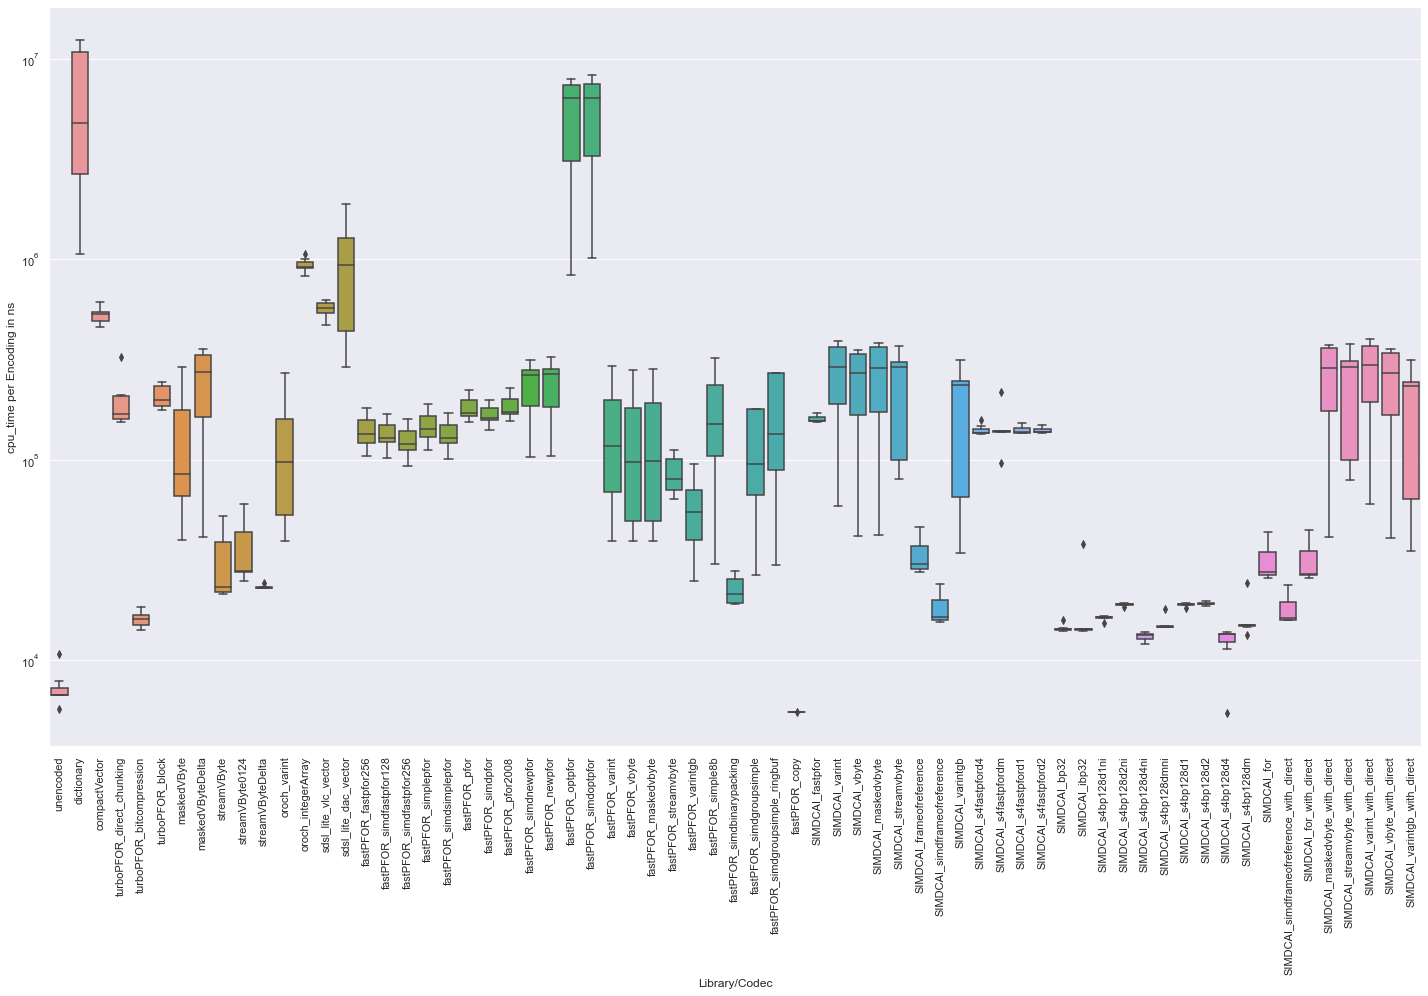

In [5]:
encoding: DataFrame = benchmark_speeds.loc[benchmark_speeds["process_type"] == "encoding"]
plot: sns.boxplot = sns.boxplot(data=encoding, x="library", y="cpu_time")

plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plot.set_yscale("log")
plt.tight_layout()
plot.set(
    xlabel='Library/Codec', 
    ylabel='cpu_time per Encoding in ns'
)
plt.savefig("visualizations/libraries_encoding.svg", format="svg")


## Encoding (interesting libs)

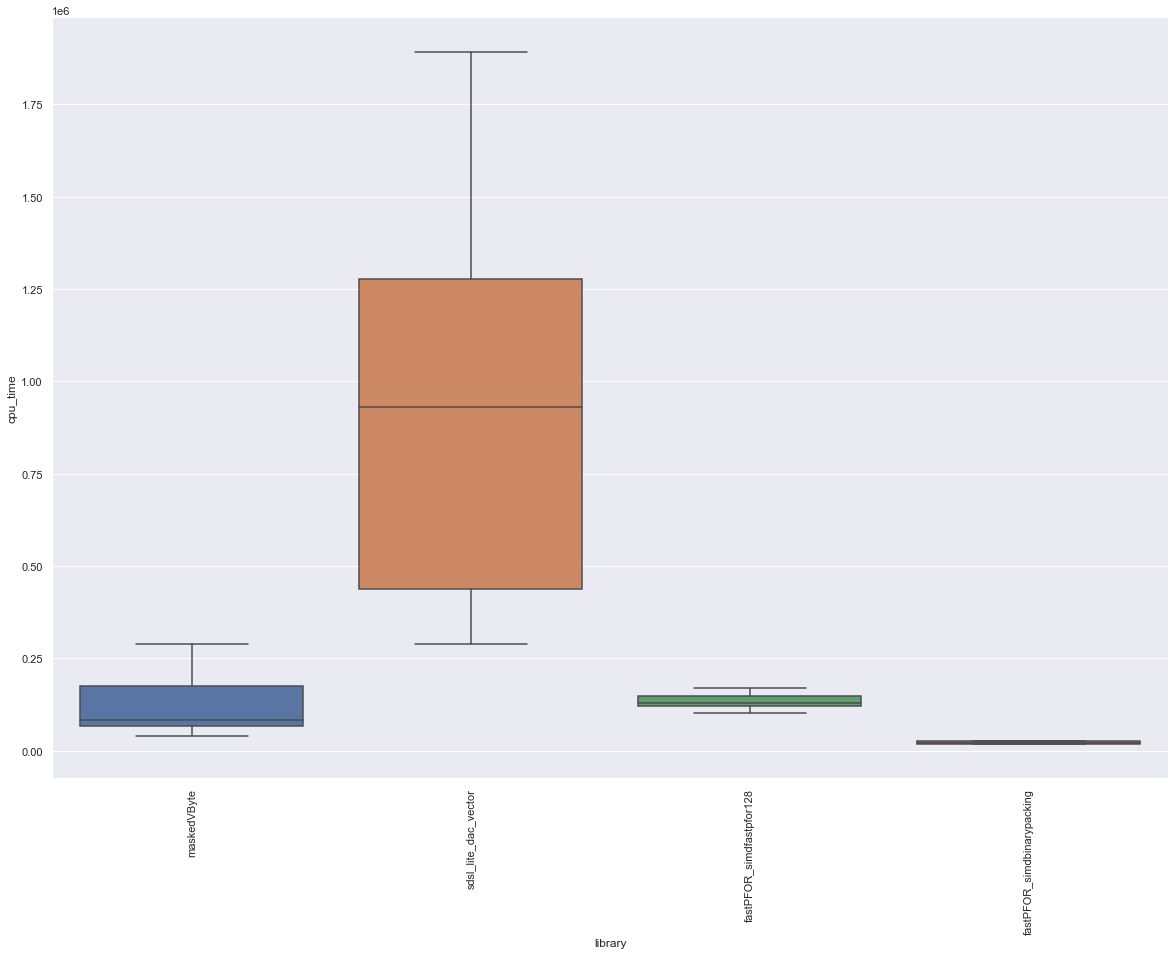

In [6]:
encoding: DataFrame = dataset_filtered.loc[dataset_filtered["process_type"] == "encoding"]
plot: sns.boxplot = sns.boxplot(data=encoding, x="library", y="cpu_time")
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plot.set_yscale("linear")

## Decoding

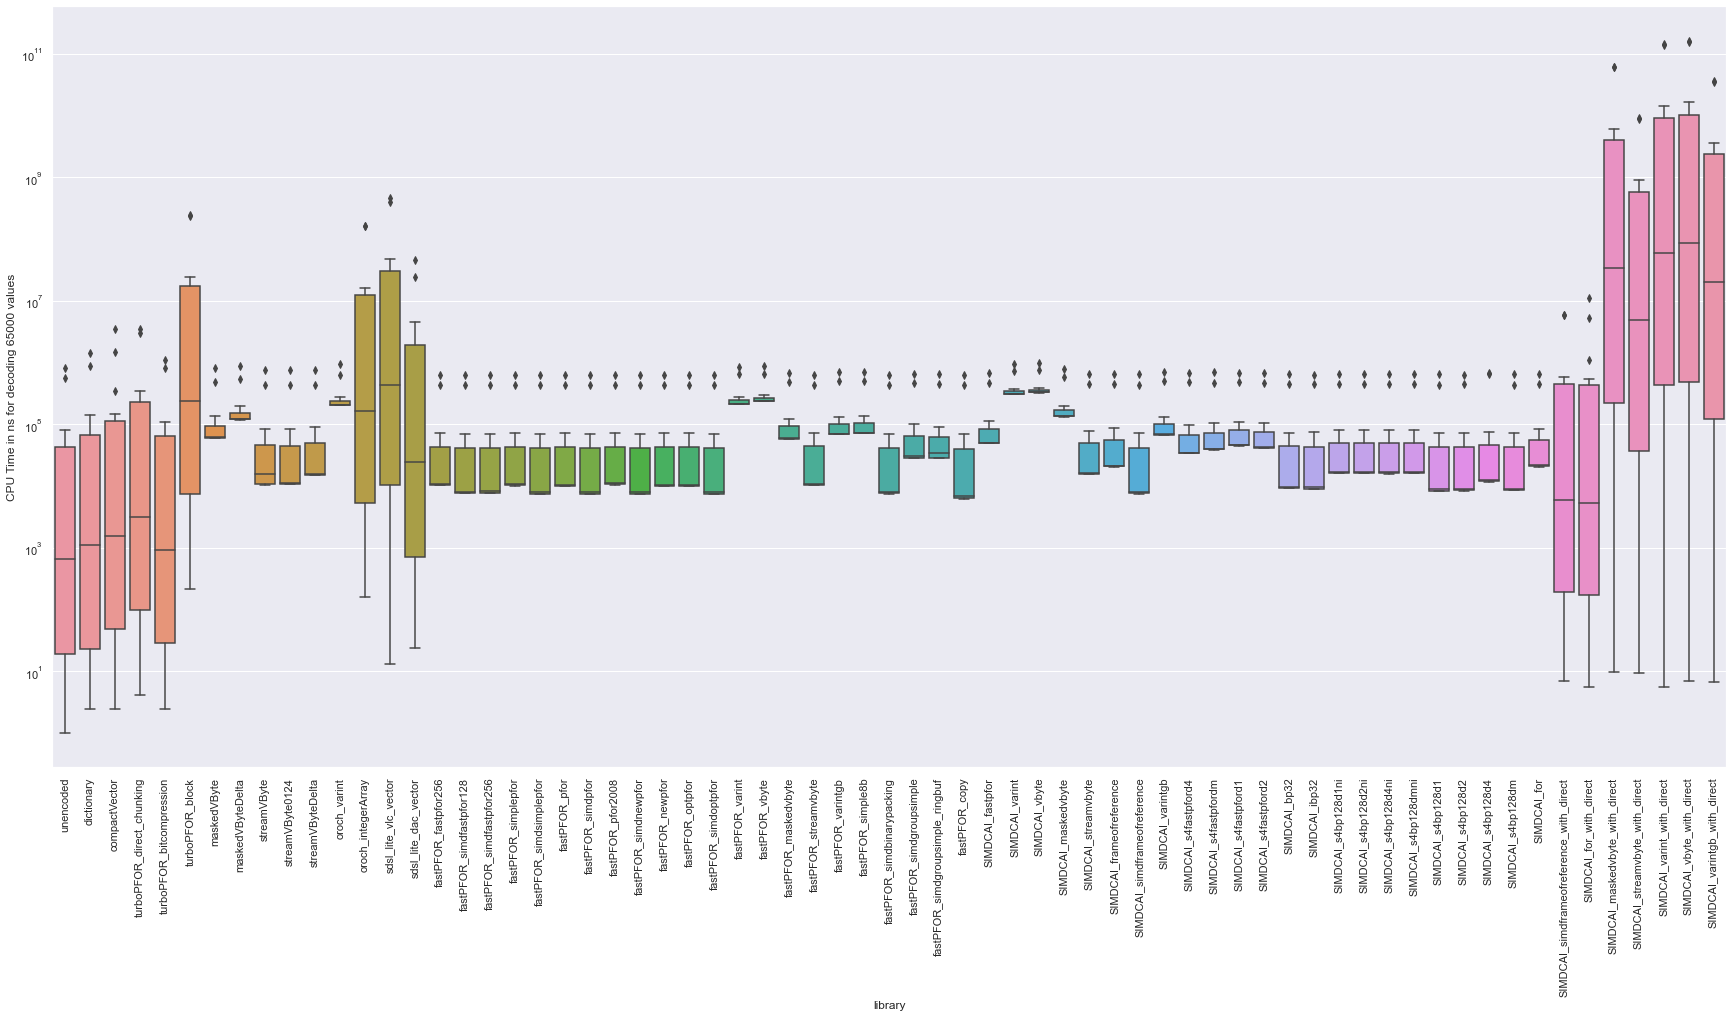

In [8]:
decoding: DataFrame = benchmark_speeds.loc[benchmark_speeds["process_type"] == "decoding_points_nocopy"]
sns.set(rc={'figure.figsize':(30,14)})

plot: sns.boxplot = sns.boxplot(data=decoding, x="library", y="cpu_time")
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plot.set_ylabel("CPU Time in ns for random access to 65000 values") 
plot.set_ylabel("Library/Codec") 
plot.set_yscale("log")

## Decoding (only fastest below 10^4)

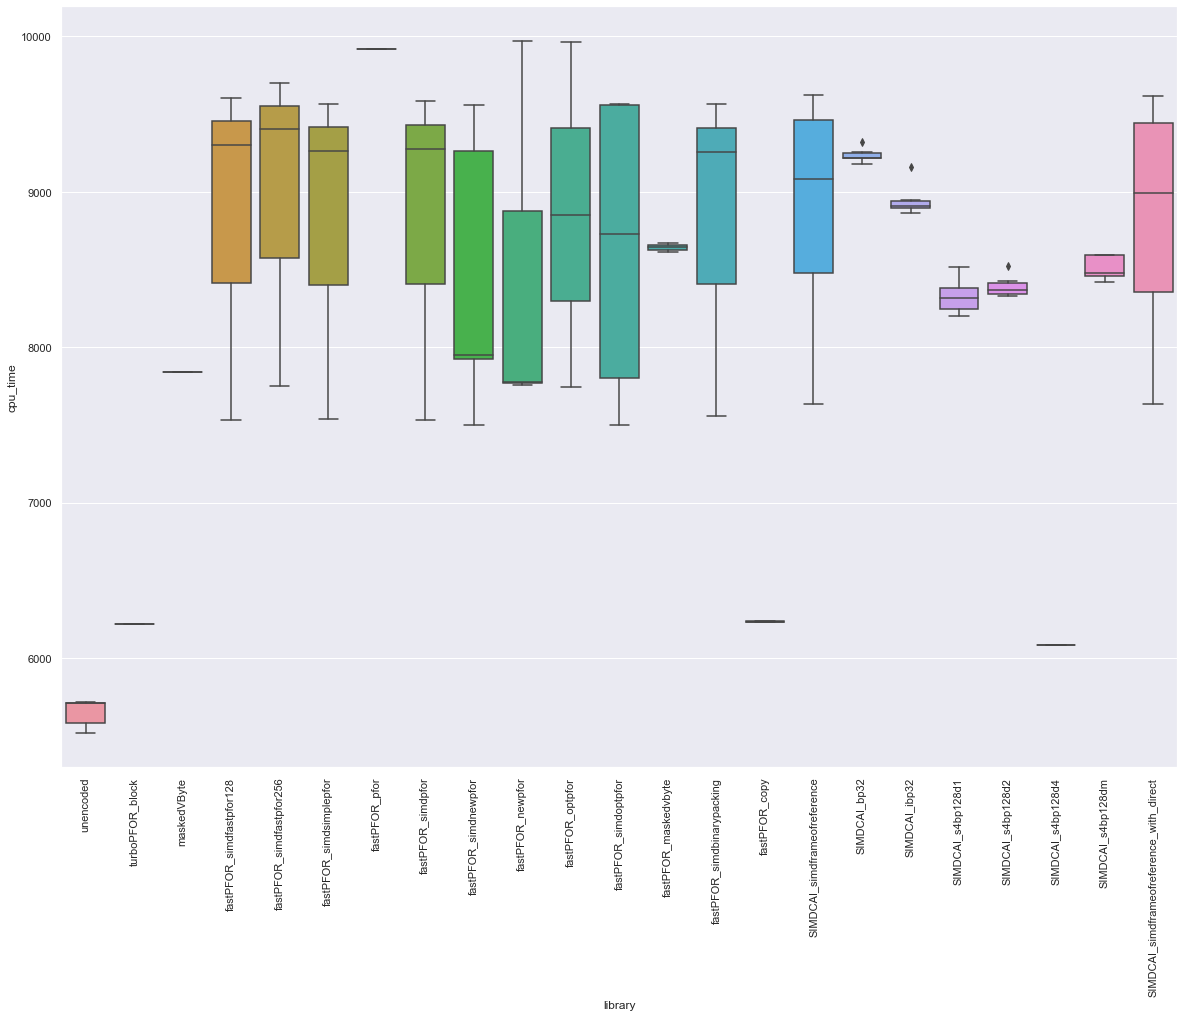

In [63]:
decoding: DataFrame = benchmark_speeds.loc[benchmark_speeds["process_type"] == "decoding"]
fastest_runtimes = decoding.loc[decoding["cpu_time"] < 10000]
plot: sns.boxplot = sns.boxplot(data=fastest_runtimes, x="library", y="cpu_time")
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plot.set_yscale("linear")

## Point based decoding

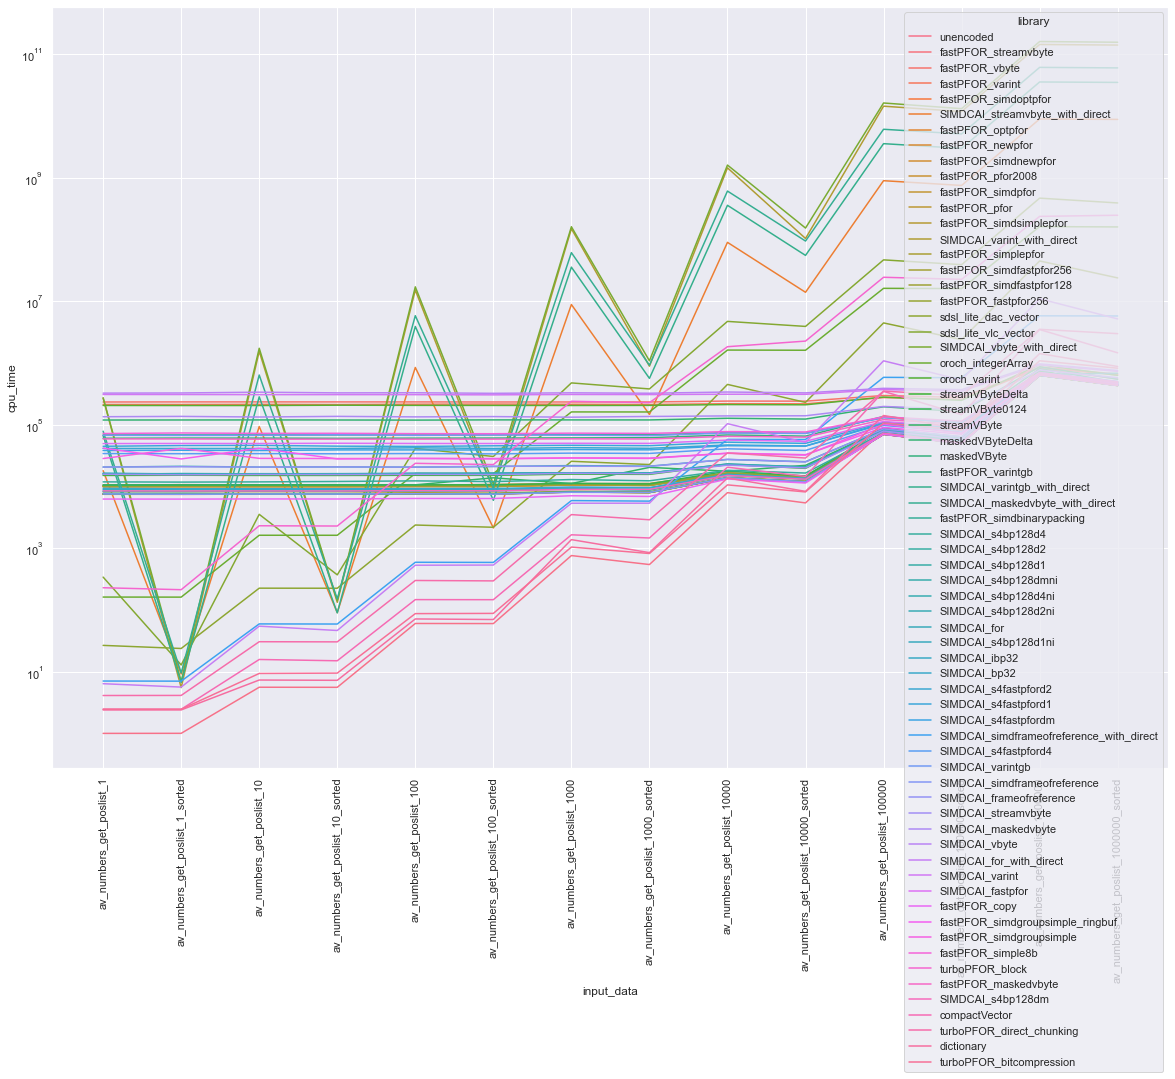

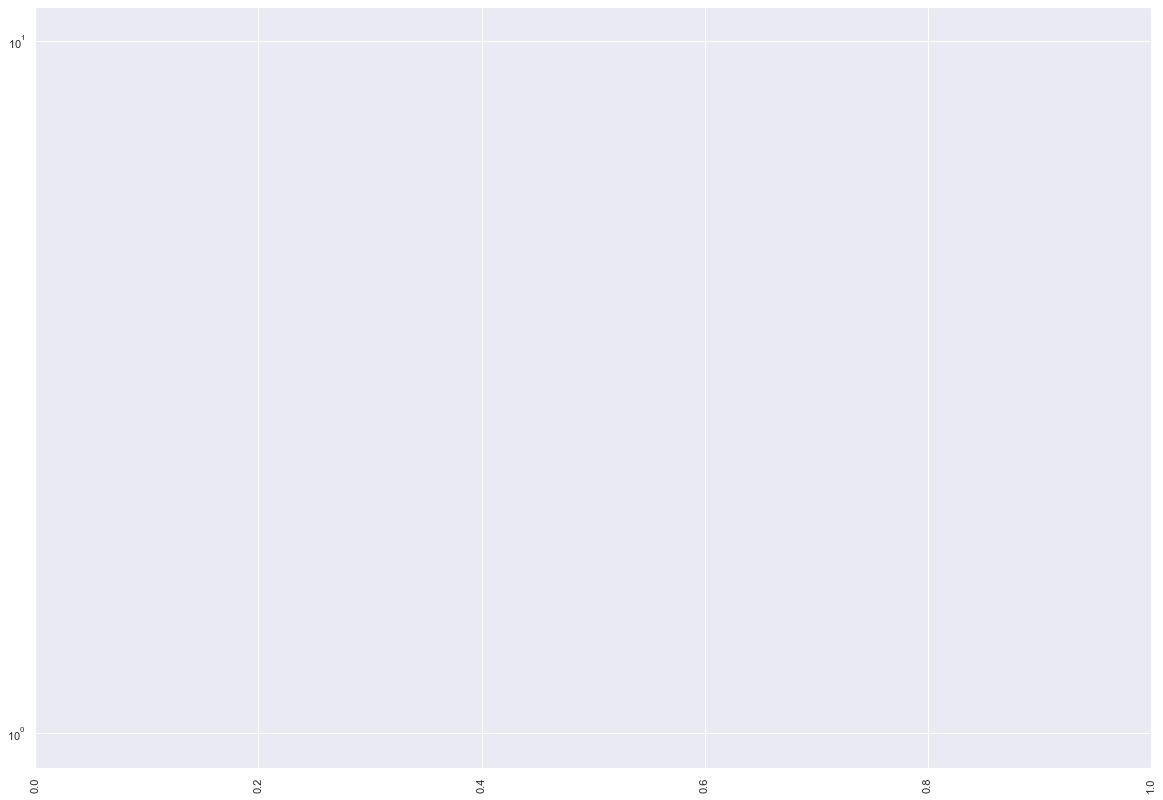

In [64]:
for data_distrib in ["av_numbers", "month_categorical"]:
    decoding_points: DataFrame = benchmark_speeds.loc[benchmark_speeds["process_type"] == "decoding_points_nocopy"]
    av_decoding_points = decoding_points[decoding_points["input_data"].str.contains(data_distrib)]
    av_decoding_points = av_decoding_points.sort_values("sizes")
    plot: sns.lineplot = sns.lineplot(data=av_decoding_points, x="input_data", y="cpu_time", hue="library")
    plot.set_yscale("log")
    plt.draw()
    plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
    plt.show()


## point decoding libs

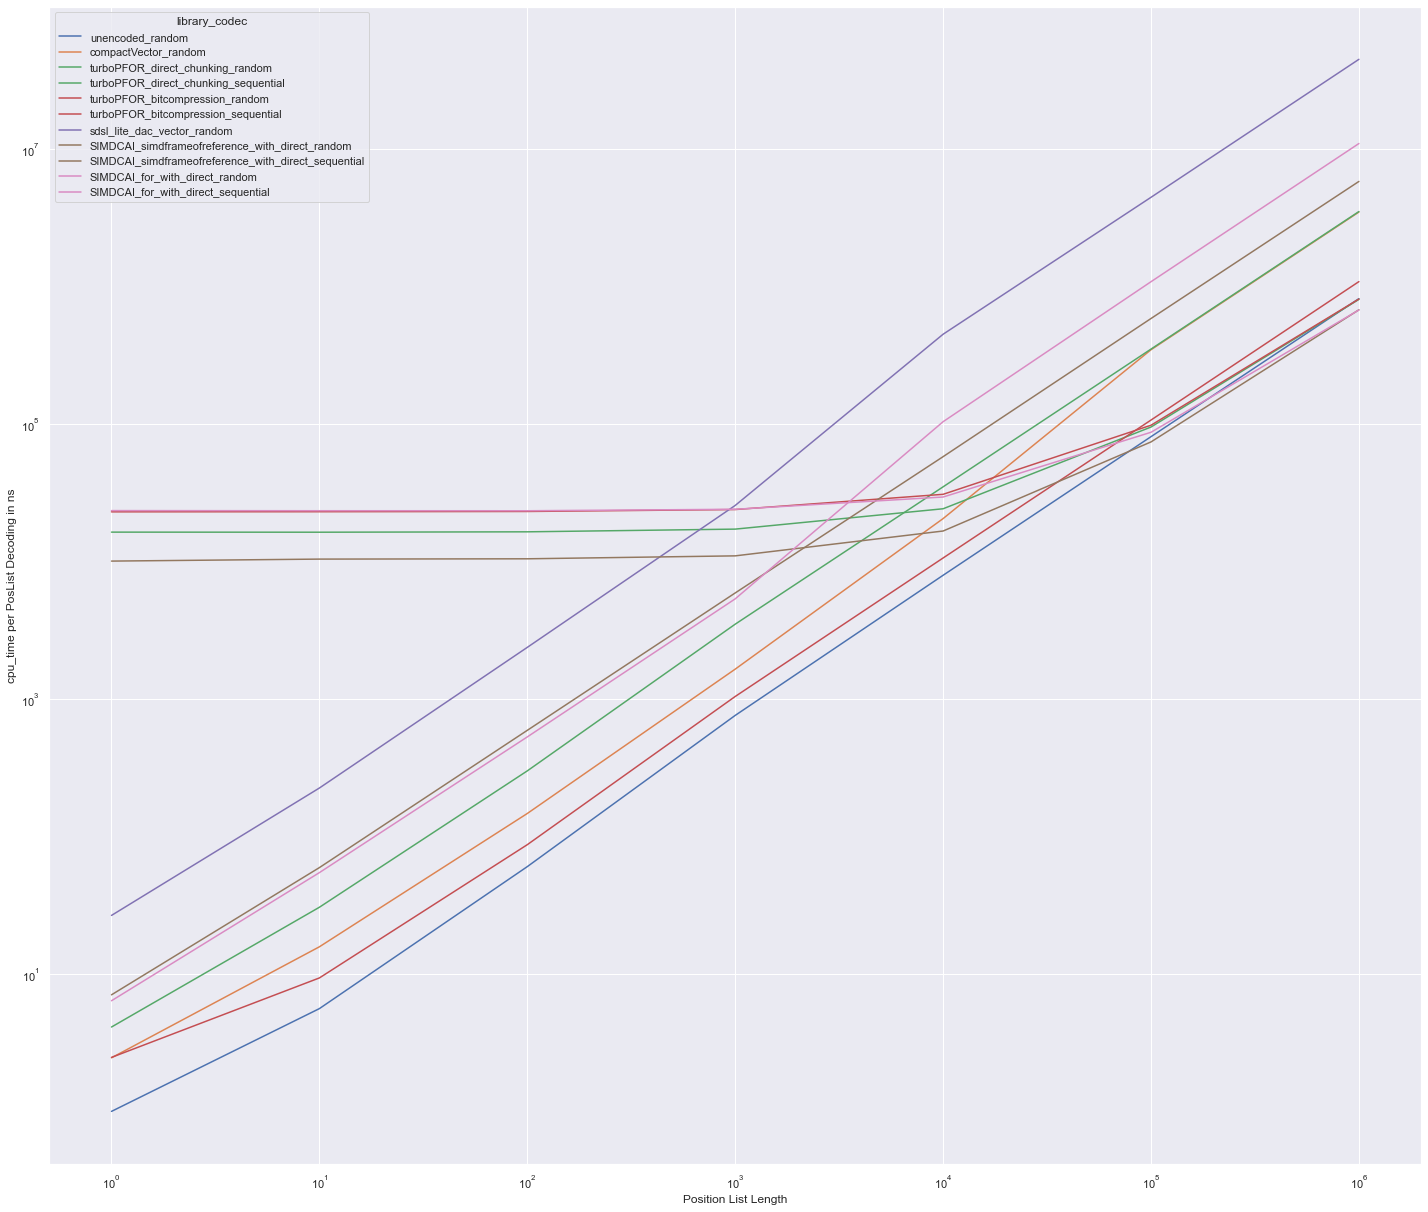

In [65]:

av_decoding_points = benchmark_speeds[benchmark_speeds["input_data"].str.contains("av_numbers")][~benchmark_speeds["input_data"].str.contains("sort")]

single_value_decodings = decoding_points[decoding_points["input_data"].str.fullmatch("av_numbers_get_poslist_1")]
fast_random_access_libs = list(single_value_decodings[single_value_decodings["cpu_time"] < 100]["library"])
fast_random_access_libs = [l for l in fast_random_access_libs if l != "dictionary"]
slow_random_access_libs = list(single_value_decodings[single_value_decodings["cpu_time"] > 1000000]["library"])
random_access_libs = fast_random_access_libs + slow_random_access_libs

av_decoding_points = av_decoding_points[av_decoding_points["process_type"].isin(["decoding_points_seq", "decoding_points_nocopy"])]
av_decoding_points["fancy_process_type"] = [p.replace("decoding_points_nocopy", "random").replace("decoding_points_seq", "sequential") for p in av_decoding_points["process_type"]]
av_decoding_points["library_codec"] = [lib + "_" + p for lib, p in zip(av_decoding_points["library"], av_decoding_points["fancy_process_type"])]

fastest_points = av_decoding_points.loc[av_decoding_points["name"].str.match(".*(" +  "|".join(fast_random_access_libs)  + ").*")]


def getPalette():
    unique_lib_names = list(fastest_points["library"].unique())
    lib_colors = dict(zip(unique_lib_names, sns.color_palette(n_colors=len(unique_lib_names))))

    codec_names = list(fastest_points["library_codec"])
    lib_names = list(fastest_points["library"])
    codec_to_lib = dict(zip(codec_names,lib_names))

    pal = {codec_name: lib_colors[codec_to_lib[codec_name]] for codec_name in codec_names}
    pal.update({"Total":"k"})
    return pal
pa = getPalette()
#print(pa)

sns.set(rc={'figure.figsize':(20,17)})

fastest_points["input_data_num"] = [int(l.split("get_poslist_")[1]) for l in fastest_points["input_data"]]
plot: sns.lineplot = sns.lineplot(data=fastest_points, x="input_data_num", y="cpu_time", hue="library_codec", palette=pa)
plt.draw()
#plot.set_xticks([0, 1, 2, 3, 4, 4.65])
#plot.set_xticklabels(['1', '10', '100', '1000', '10000', '65000'] ,rotation=0)
plot.set_xscale("log")
plot.set_yscale("log")
plt.tight_layout()
plot.set(
    xlabel='Position List Length', 
    ylabel='cpu_time per PosList Decoding in ns'
)
plt.savefig("visualizations/point_decoding_random_access_fastest.svg", format="svg")
#fastest_points["input_data_num"]

slow random access libs:  []


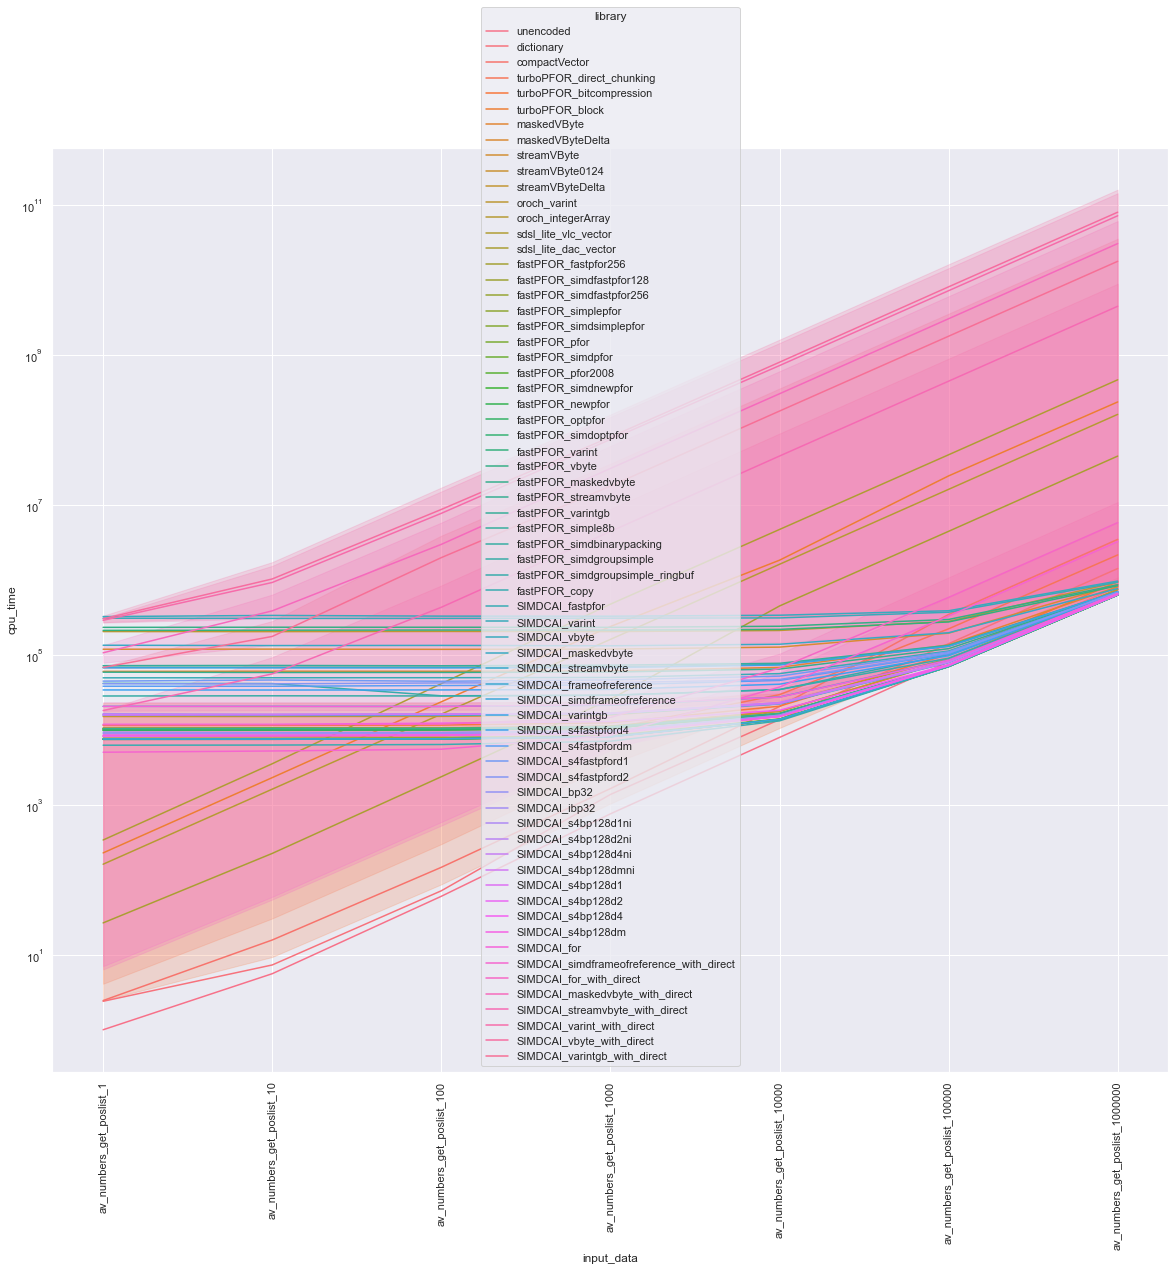

In [66]:
print("slow random access libs: ", slow_random_access_libs)
fastest_points_1 = av_decoding_points.loc[av_decoding_points["name"].str.match(".*(" +  "|".join(slow_random_access_libs)  + ").*")]
plot: sns.lineplot = sns.lineplot(data=fastest_points_1, x="input_data", y="cpu_time", hue="library")
plt.draw()
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plot.set_yscale("log")
plt.show()


random access libs:  ['unencoded', 'compactVector', 'turboPFOR_direct_chunking', 'turboPFOR_bitcompression', 'sdsl_lite_dac_vector', 'SIMDCAI_simdframeofreference_with_direct', 'SIMDCAI_for_with_direct']


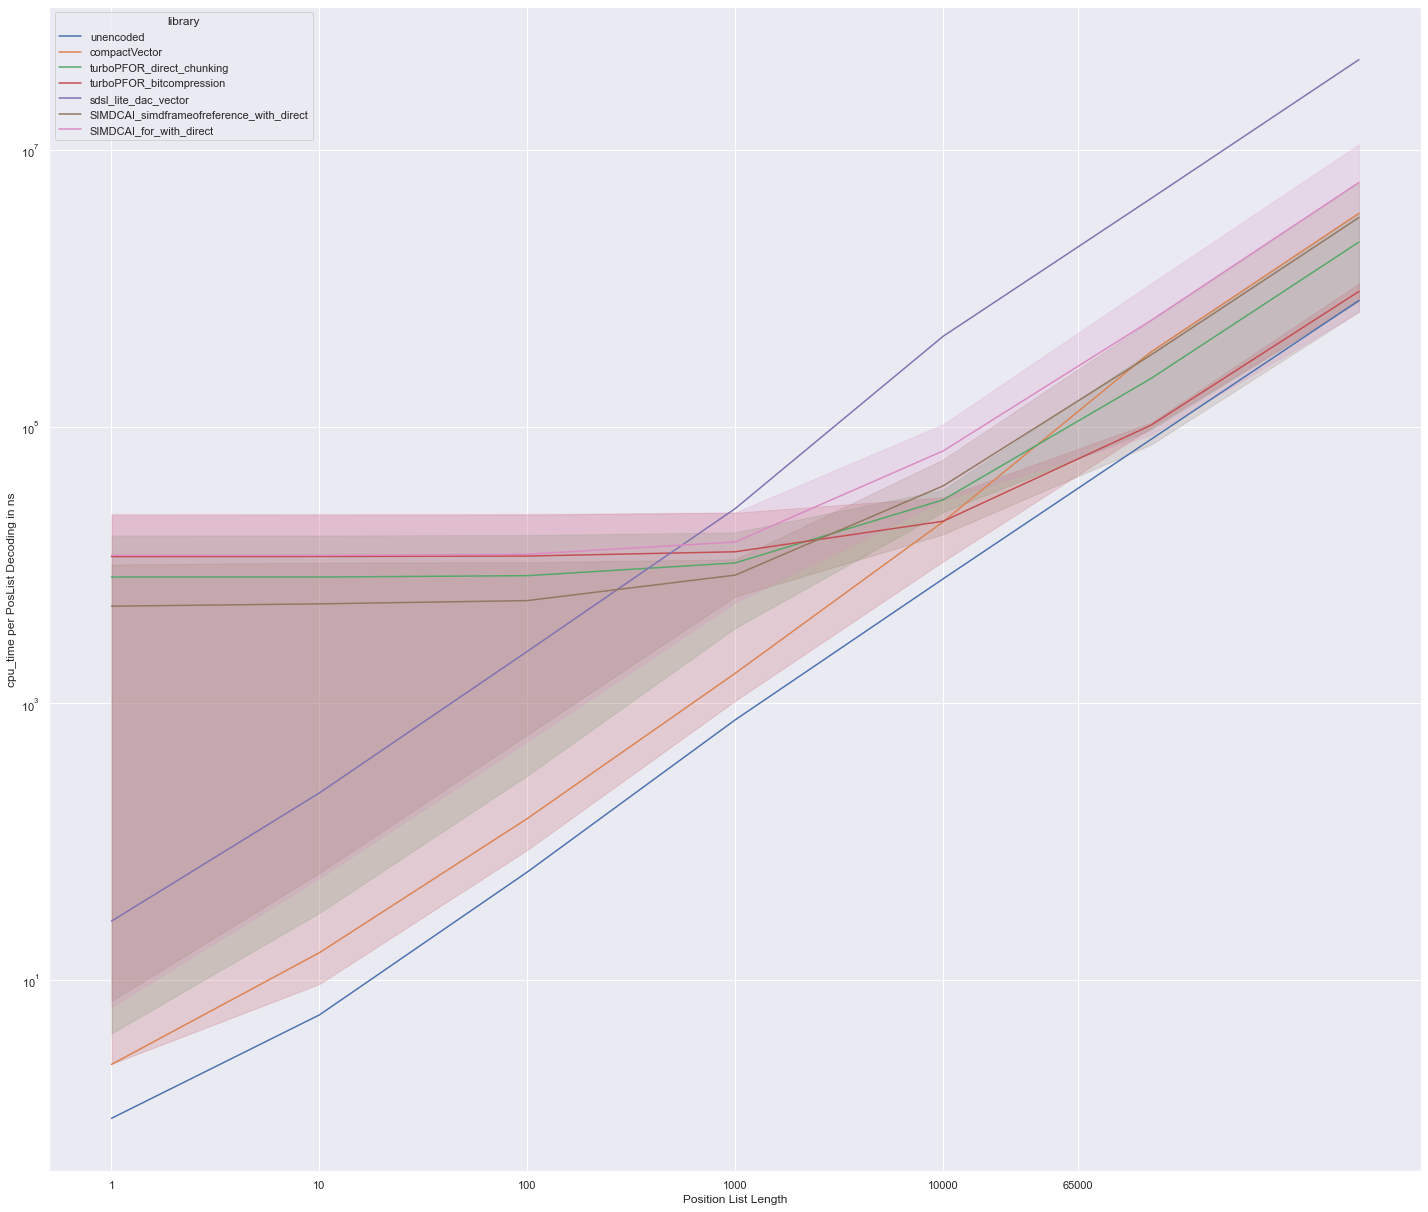

In [67]:
print("random access libs: ", random_access_libs)
fastest_points_2 = av_decoding_points.loc[av_decoding_points["name"].str.match(".*(" +  "|".join(random_access_libs)  + ").*")]
plot: sns.lineplot = sns.lineplot(data=fastest_points_2, x="input_data", y="cpu_time", hue="library")
plt.draw()
plot.set_xticks([0, 1, 2, 3, 4, 4.65])
plot.set_xticklabels(['1', '10', '100', '1000', '10000', '65000'] ,rotation=0)
plot.set_yscale("log")
plt.tight_layout()
plot.set(
    xlabel='Position List Length', 
    ylabel='cpu_time per PosList Decoding in ns'
)
plt.savefig("visualizations/point_decoding_random_access_all.svg", format="svg")


## Decoding Point Based (only random access libs, detailed view for accessing 10000 out of 65000 points)

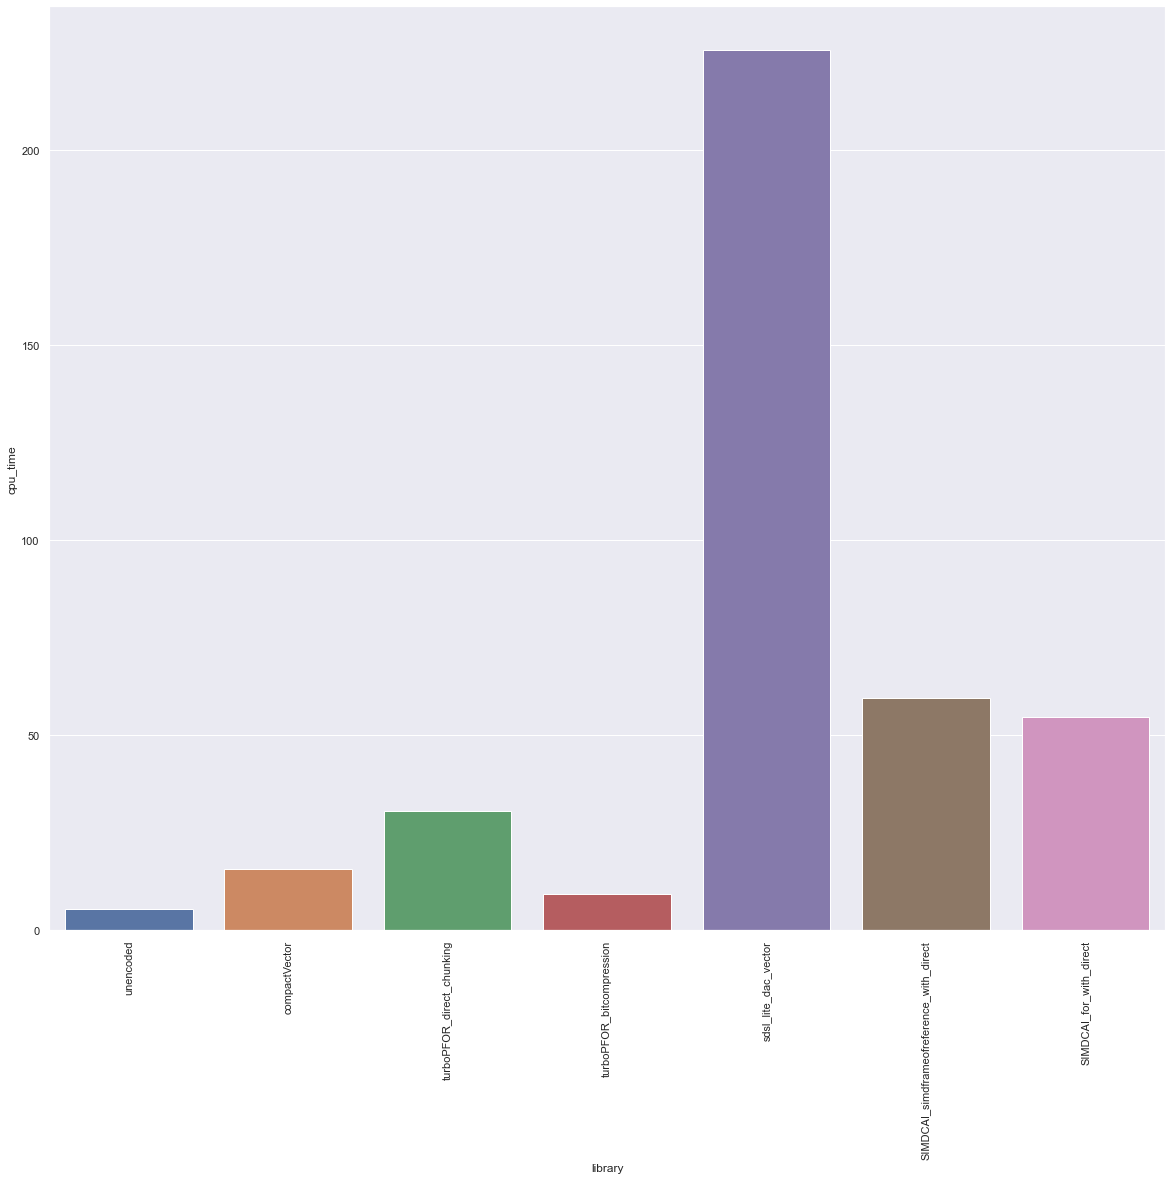

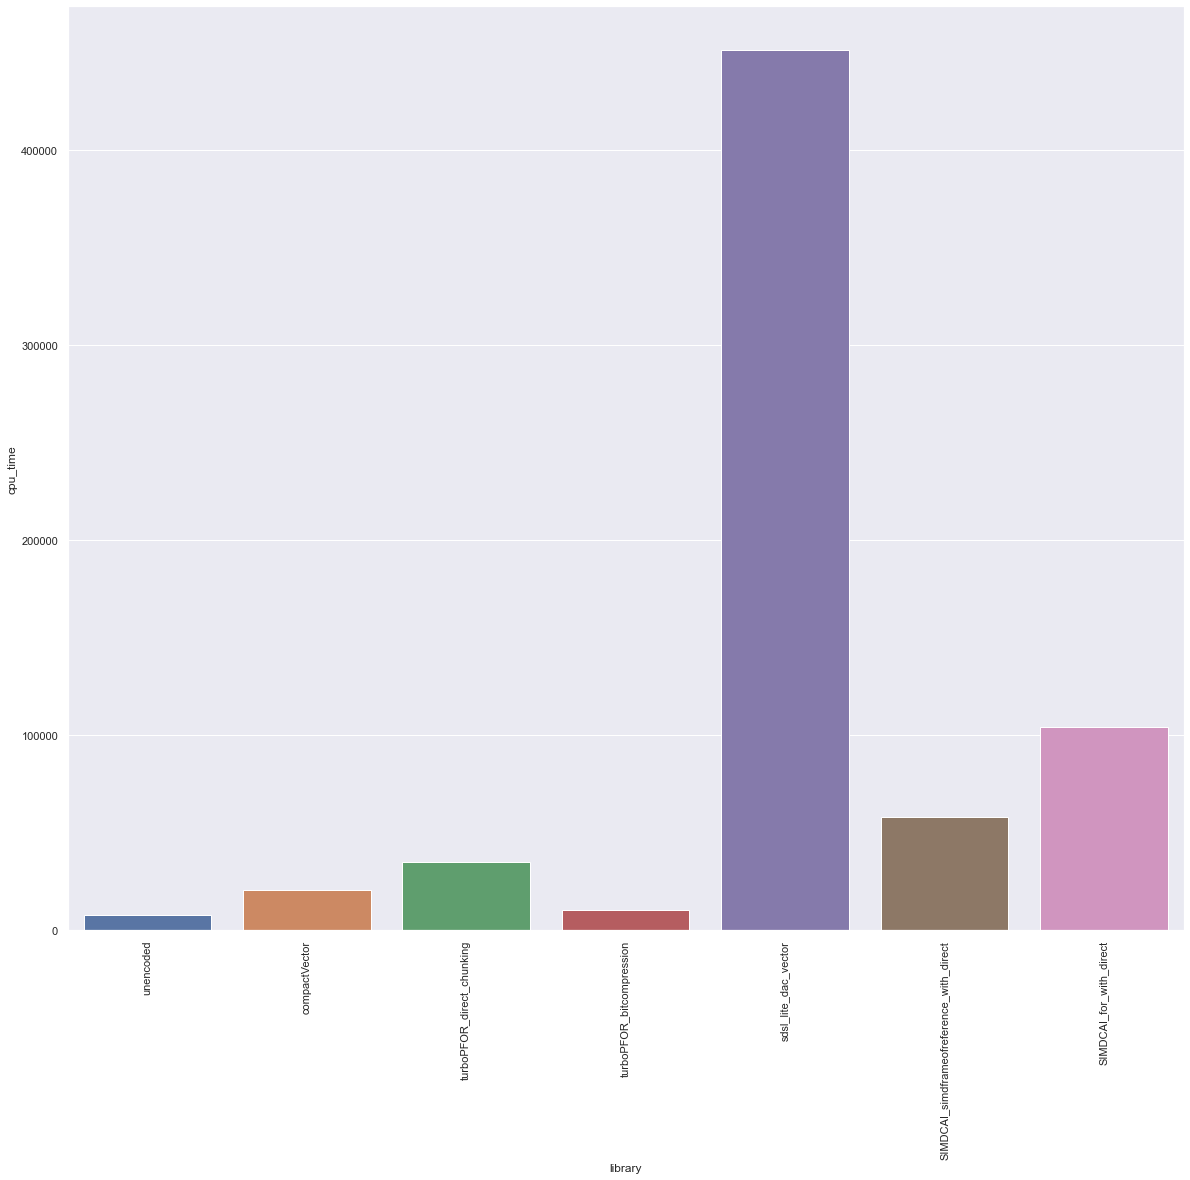

In [68]:
 for poslist_length in ["av_numbers_get_poslist_10", "av_numbers_get_poslist_10000"]:
    decoding_points: DataFrame = benchmark_speeds.loc[benchmark_speeds["process_type"].str.contains("decoding_points_nocopy")]
    fastest_points = decoding_points.loc[decoding_points["name"].str.match(".*(" +  "|".join(fast_random_access_libs)  + ").*")]
    fastest_points = fastest_points.loc[fastest_points["input_data"] == poslist_length]
    plot: sns.lineplot = sns.barplot(data=fastest_points, x="library", y="cpu_time")
    plot.set_yscale("linear")
    plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
    plt.show()


## Sequential decoding speed of random access libs

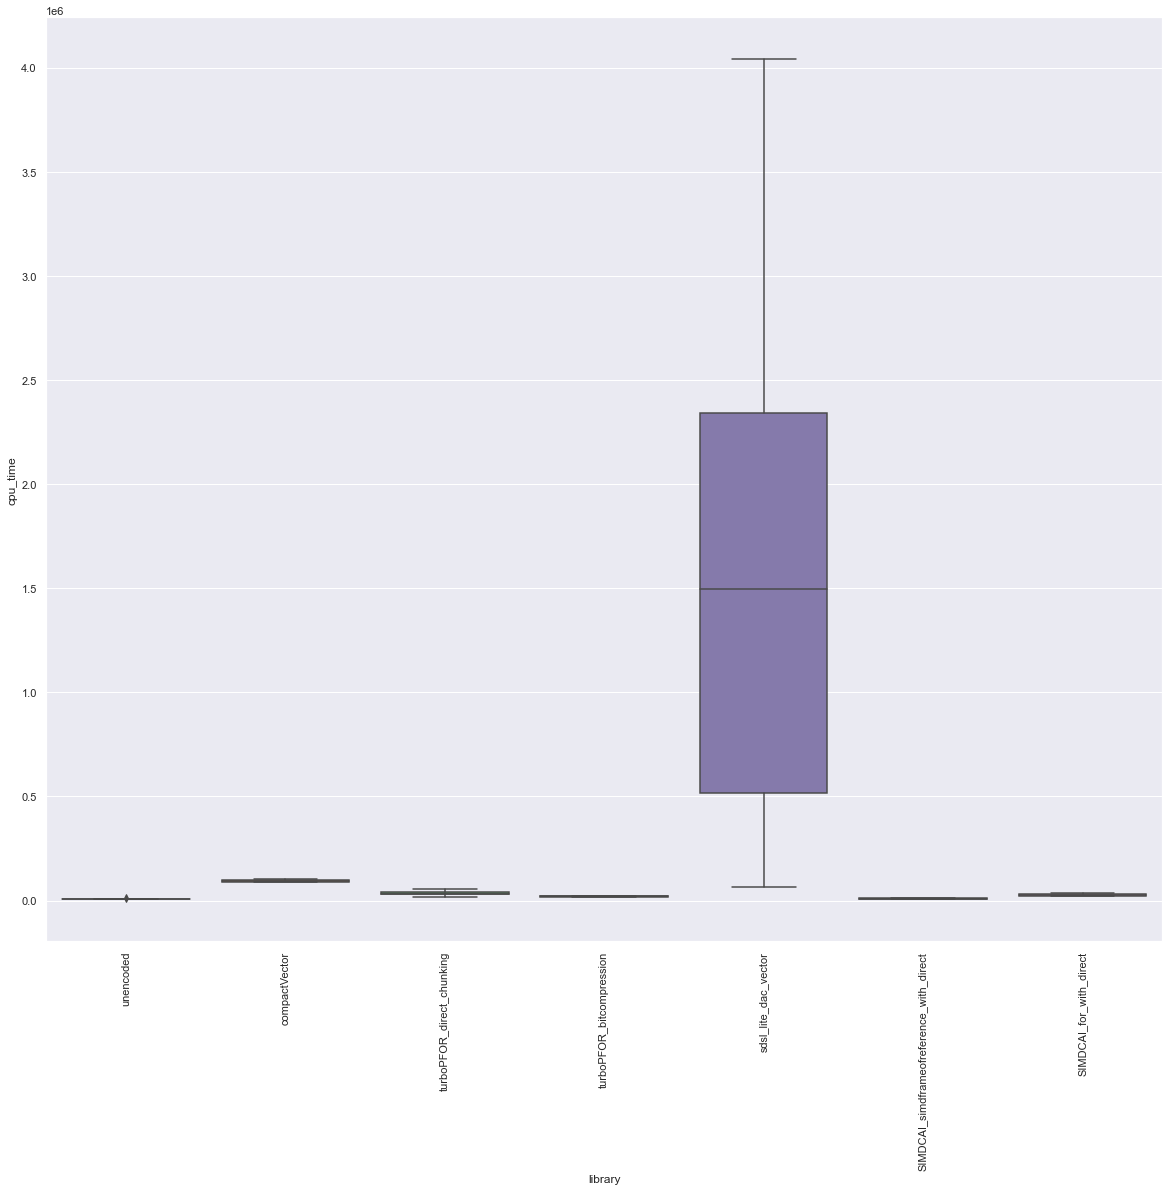

In [69]:
decoding: DataFrame = benchmark_speeds.loc[benchmark_speeds["process_type"] == "decoding"]
fastest_runtimes = decoding.loc[decoding["library"].str.match(".*(" +  "|".join(fast_random_access_libs)  + ").*")]
plot: sns.boxplot = sns.boxplot(data=fastest_runtimes, x="library", y="cpu_time")
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plot.set_yscale("linear")

## compression rates of fast random access libs (mean across all data distributions)

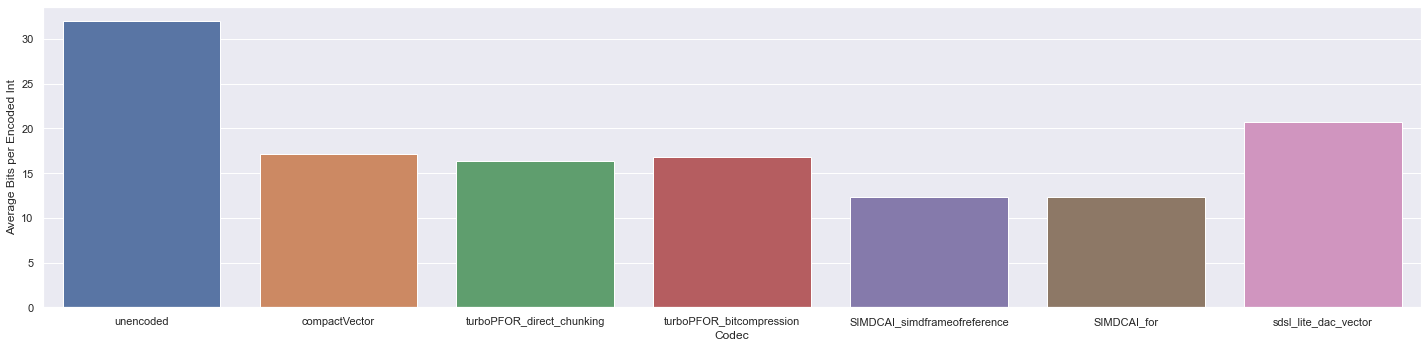

In [70]:
compression_stats: DataFrame = pd.read_csv(benchmark_compression_file)
compression_stats["name"] = [l.replace("SIMDCompressionAndIntersection", "SIMDCAI") for l in compression_stats["name"]]
compression_stats = compression_stats.loc[compression_stats["bitsPerInt"] != -1]

libs = [l.replace("_with_direct", "")for l in fast_random_access_libs]
fast_point_compression_stats = compression_stats.loc[compression_stats["name"].str.match(".*(" +  "|".join(libs)  + ").*")]

fast_point_compression_stats = fast_point_compression_stats[~fast_point_compression_stats["name"].str.match(".*with_select")]

def avgBitsPerInt(group):
    group["avgBitsPerInt"] = group["bitsPerInt"].mean()
    return group
fast_point_compression_stats = fast_point_compression_stats.groupby("name").apply(avgBitsPerInt)

sns.set(rc={'figure.figsize':(20,5)})

plot = sns.barplot(data=fast_point_compression_stats, x="name", y="avgBitsPerInt")
plot.set_xticklabels(plot.get_xticklabels(),rotation=0)


plt.tight_layout()
plot.set(
    xlabel='Codec', 
    ylabel='Average Bits per Encoded Int'
)
plt.savefig("point_decoding_bits_per_int_fastest.svg", format="svg")

# todo: sort by same order
# print(libs)
# fast_point_compression_stats

## compression rates of fast random access libs

<AxesSubplot:xlabel='dataName', ylabel='bitsPerInt'>

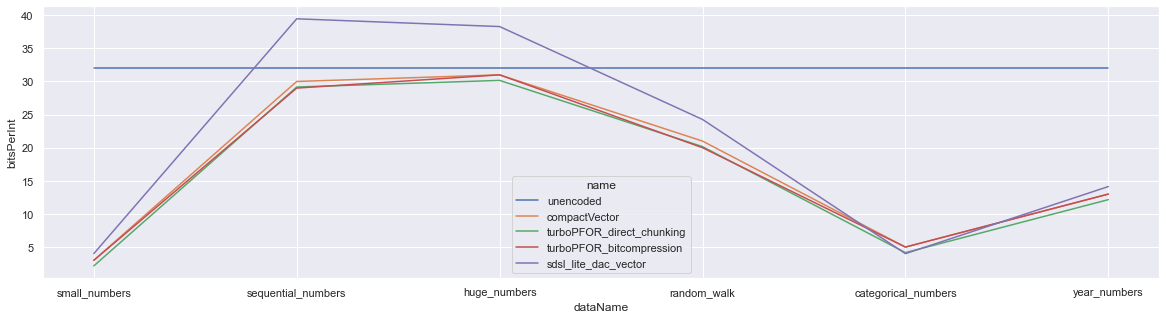

In [71]:
compression_stats: DataFrame = pd.read_csv(benchmark_compression_file)
compression_stats = compression_stats.loc[compression_stats["bitsPerInt"] != -1]
compression_stats = compression_stats.loc[compression_stats["name"].str.match(".*(" +  "|".join(fast_random_access_libs)  + ").*")]
sns.lineplot(data=compression_stats, x="dataName", y="bitsPerInt", hue="name")

## Compression

<AxesSubplot:xlabel='dataName', ylabel='bitsPerInt'>

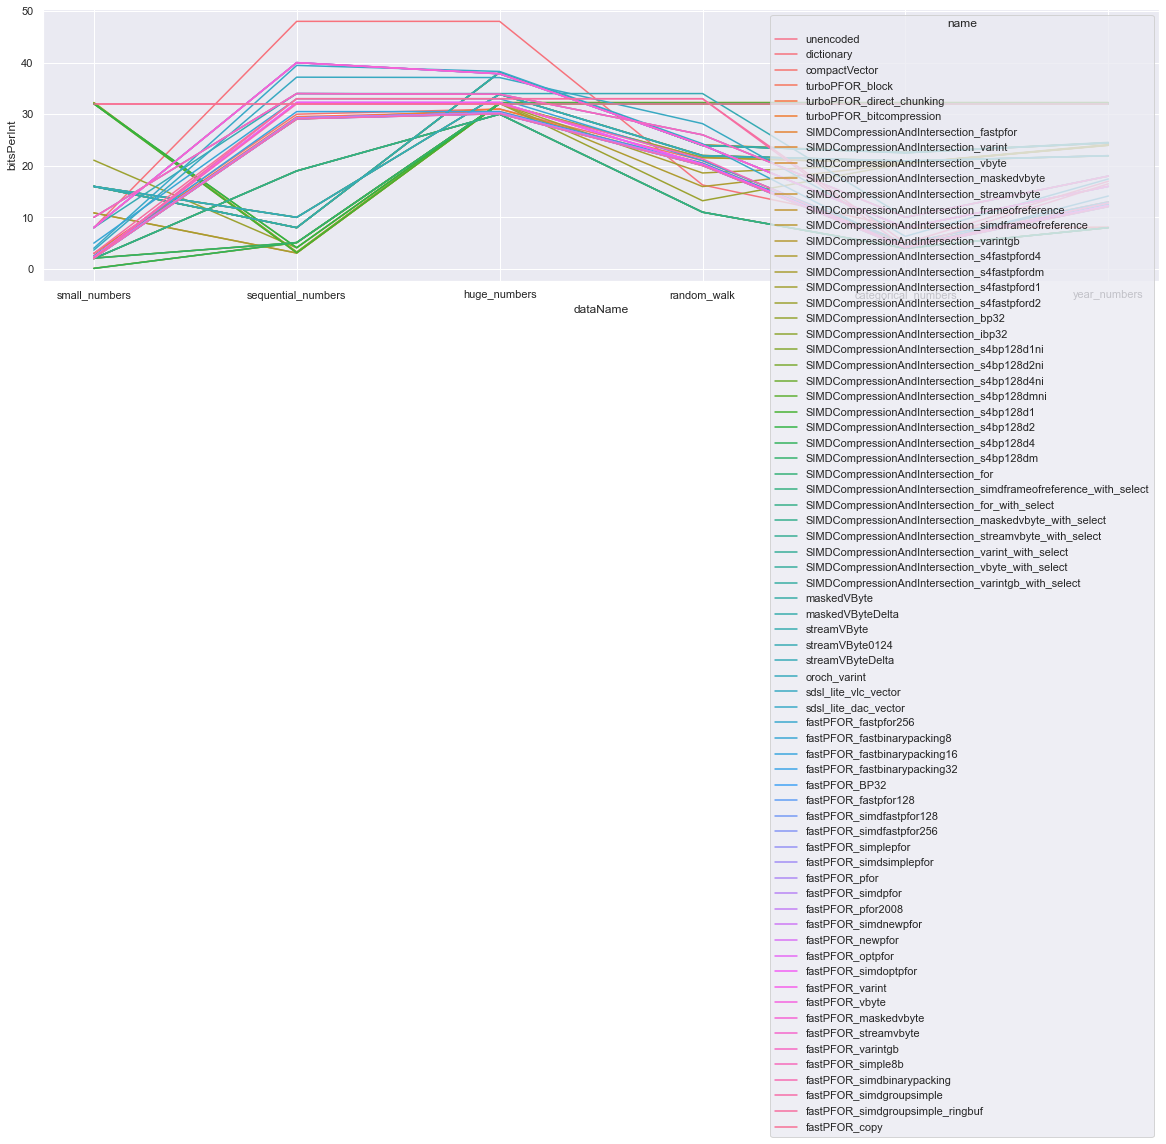

In [72]:
compression_stats: DataFrame = pd.read_csv(benchmark_compression_file)
compression_stats = compression_stats.loc[compression_stats["bitsPerInt"] != -1]
sns.lineplot(data=compression_stats, x="dataName", y="bitsPerInt", hue="name")

## Compression (only smallest)

<AxesSubplot:xlabel='dataName', ylabel='bitsPerInt'>

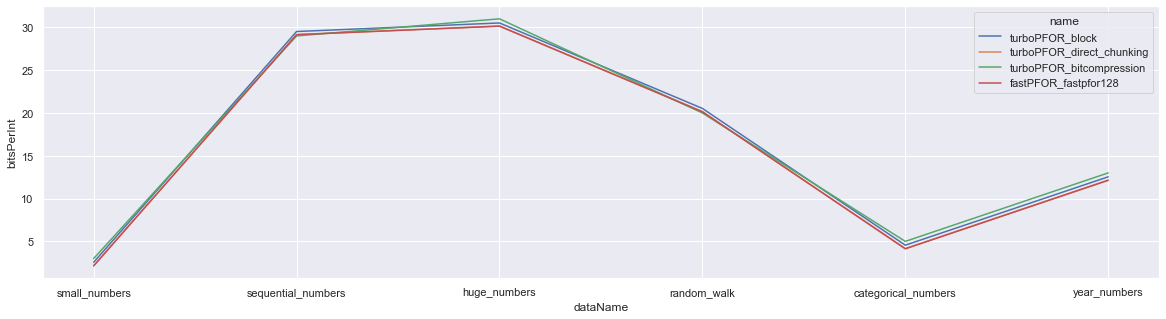

In [73]:
compression_stats: DataFrame = pd.read_csv(benchmark_compression_file)
compression_stats = compression_stats.loc[compression_stats["bitsPerInt"] != -1]
compression_stats = compression_stats.loc[compression_stats["name"].str.match(".*(fastPFOR_fastpfor128|turboPFOR).*")]

sns.lineplot(data=compression_stats, x="dataName", y="bitsPerInt", hue="name")

## Compression (interesting libs)

<AxesSubplot:xlabel='dataName', ylabel='bitsPerInt'>

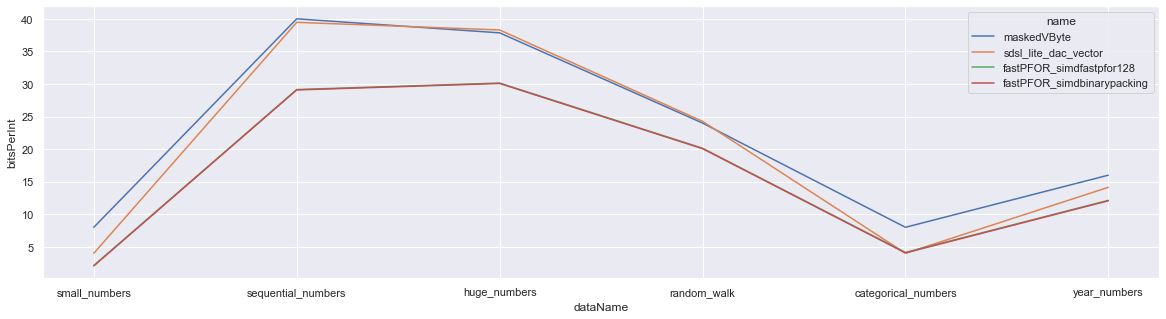

In [74]:
compression_stats: DataFrame = pd.read_csv(benchmark_compression_file)
compression_stats = compression_stats.loc[compression_stats["bitsPerInt"] != -1]
compression_stats_filtered = compression_stats.loc[compression_stats["name"].isin(dataset_filtered["library"])]
sns.lineplot(data=compression_stats_filtered, x="dataName", y="bitsPerInt", hue="name")

## Pareto

In [75]:
compression_stats["library"] = compression_stats["name"]
combined = benchmark_speeds.merge(compression_stats, left_on=["library", "input_data"], right_on=["library", "dataName"], how="inner")
combined = combined.loc[(combined["process_type"] == "encoding")] # we don't really care about encoding times (todo: proper weighting)

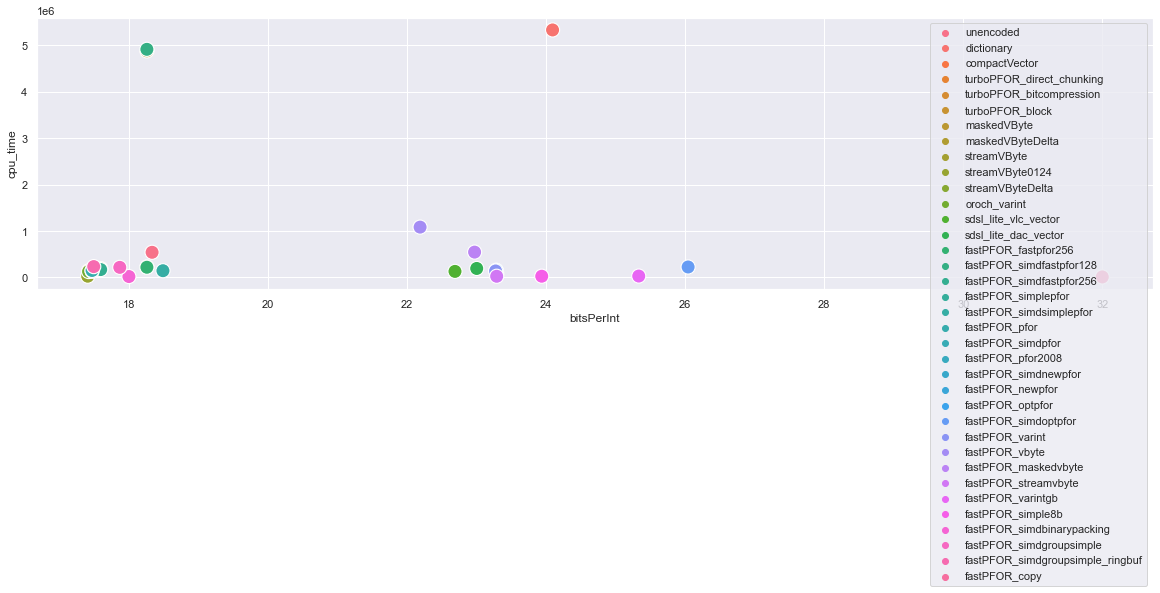

In [76]:
x = combined.groupby("library")['bitsPerInt'].mean()
y = combined.groupby("library")['cpu_time'].mean()
names = combined.library.unique()
plot = sns.scatterplot(x, y, hue=names, s=200)

## Pareto (interesting libs)

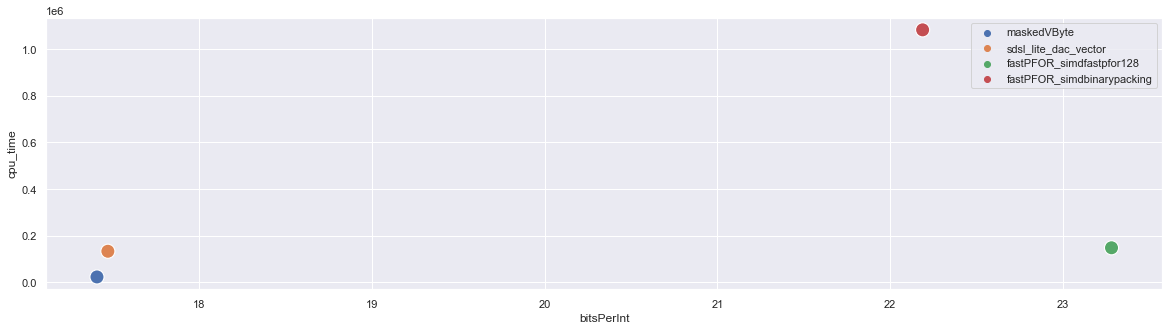

In [77]:
combined_filtered = combined.loc[(combined["library"].isin(most_interesting_libraries))]
x = combined_filtered.groupby("library")['bitsPerInt'].mean()
y = combined_filtered.groupby("library")['cpu_time'].mean()
plot = sns.scatterplot(x, y, hue=combined_filtered.library.unique(), s=200)

## Pareto (even more interesting libs :D)

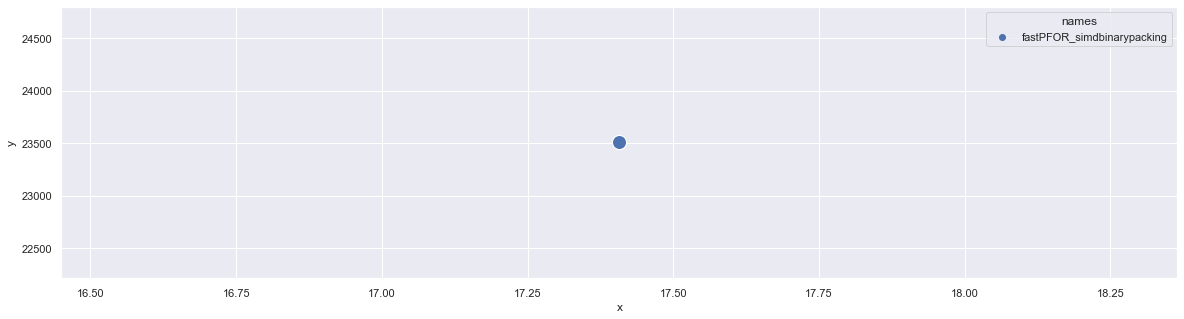

In [78]:
c = combined.groupby("library", sort=False)
x = c['bitsPerInt'].mean()
y = c['cpu_time'].mean()
names = combined.library.unique()
data = pd.DataFrame({"x": x, "y": y, "names": names})
data = data[data.x < 17.7]
data = data[data.y < 50000]
#data = data[data.names.str.contains("turbo")]
plot = sns.scatterplot(x=data.x, y=data.y, hue=data.names, s=200)


## Pareto (even more interesting libs :D)

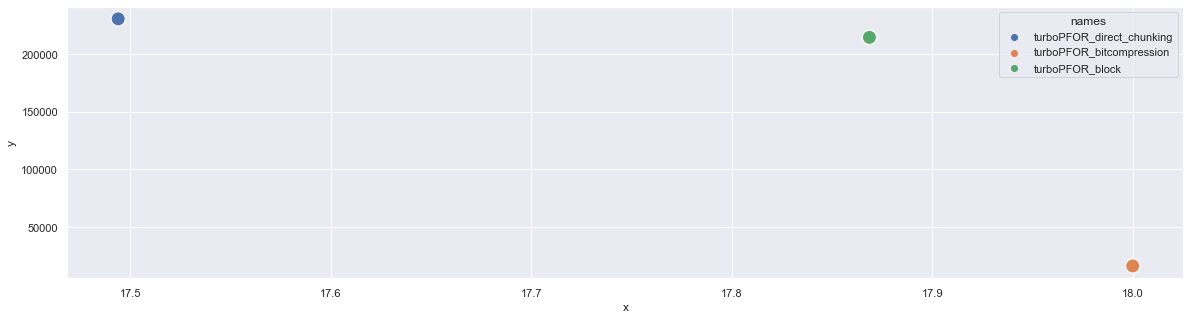

In [79]:
c = combined.groupby("library", sort=False)
x = c['bitsPerInt'].mean()
y = c['cpu_time'].mean()
names = combined.library.unique()
data = pd.DataFrame({"x": x, "y": y, "names": names})
data = data[data.names.str.contains("turbo")]
plot = sns.scatterplot(x=data.x, y=data.y, hue=data.names, s=200)

## Copy vs nocopy

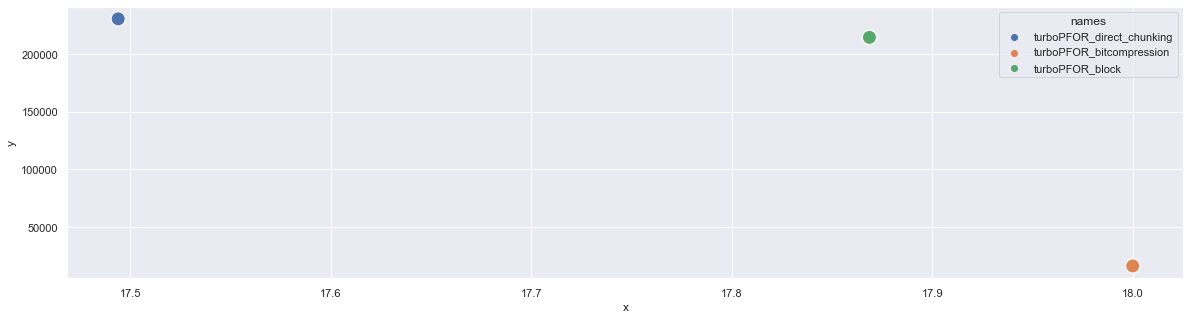

In [80]:
c = combined.groupby("library", sort=False)
x = c['bitsPerInt'].mean()
y = c['cpu_time'].mean()
names = combined.library.unique()
data = pd.DataFrame({"x": x, "y": y, "names": names})
data = data[data.names.str.contains("turbo")]
plot = sns.scatterplot(x=data.x, y=data.y, hue=data.names, s=200)
